In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [117]:
class Parameter:
    
    def __init__(self, value, children=[], op=''):
        self.value = value
        self.gradient = 0
        self.children = children
        self.op = op
        self._backprop = lambda: None
        
    def __add__(self, other):
        other = other if isinstance(other, Parameter) else Parameter(other)
        result = Parameter(self.value + other.value, [self, other], '+')
        
        def _backprop():
            self.gradient += result.gradient
            other.gradient += result.gradient
            
        result._backprop = _backprop
        
        return result
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Parameter) else Parameter(other)
        result = Parameter(self.value * other.value, [self, other], '*')
        
        def _backprop():
            self.gradient += other.value * result.gradient
            other.gradient += self.value * result.gradient
            
        result._backprop = _backprop
        
        return result
    
    def __sub__(self, other):
        return self + (other * (-1))
    
    def relu(self):
        result = Parameter(0 if self.value < 0 else self.value, [self], 'ReLU')
        
        def _backprop():
            self.gradient += (result.value > 0) * result.gradient
        result._backprop = _backprop
            
        return result
    
    def backpropagation(self):
        
        allparams = []
        visited = []
        
        def build_params(p):
            if p not in visited:
                visited.append(p)
                for child in p.children:
                    build_params(child)
                allparams.append(p)
        build_params(self)
        
        self.gradient = 1
        for p in reversed(allparams):
            p._backprop()
        
            
    

In [164]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Parameter(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Parameter(0)
        
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu()
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
class NeuralNetwork:
    
    def __init__(self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]
        self.training_progress = []
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def train(self, xs, ys, iterations, learning_rate):
        training_progress = []
        
        for i in range(iterations):
            pred = [self(x) for x in xs]
            loss = sum([((pr-y) * (pr-y)) for pr, y in zip(pred,ys)])
            training_progress.append(loss.value)
            
            for p in self.parameters():
                p.gradient = 0
                
            loss.backpropagation()
            
            for p in self.parameters():
                p.value += learning_rate * (-1) * p.gradient
                
            self.training_progress = training_progress

In [246]:
# test with f(x) = 2x
xs = [[0.1], [0.2], [0.3], [0.4]]
ys = [0.2,0.4,0.6,0.8]

nn = NeuralNetwork(1, [4,4,1])
nn.train(xs,ys,100,0.01)

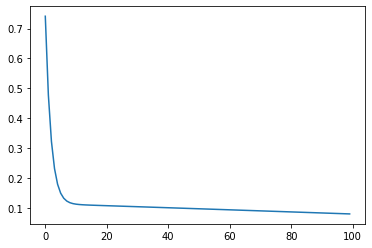

In [247]:
plt.plot(nn.training_progress)

In [252]:
nn([0.2]).value

0.4667249082626712